<a href="https://colab.research.google.com/github/Nirzu97/pyprobml/blob/densenet-torch/notebooks/densenet_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense networks

We implement DenseNet.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display 

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

import random
import os
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir figures # for saving plots

# Dense blocks

A conv block uses BN-activation-conv in order.

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

A DenseBlock is a sequence of conv-blocks, each consuming as input all previous outputs.

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

Example: we start with 3 channels, make a DenseBlock with 2 conv-blocks each with 10 channels, to get an output with 23 channels.

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

# Transition layers

To prevent the number of channels exploding, we can add a transition layer, that uses 1x1 convolution. We can also reduce the spatial resolution using stride 2 average pooling.

In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Below we show an example where we map the 23 channels back down to 10, and halve the spatial dimensions.

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# Full model

The first part of the model is similar to resnet.

In [7]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The "backbone" is 4 dense-blocks, each of which has 4 conv-blocks with 32 channels. Since the number of channels increases for each conv-block, the parameter 32 is called the "growth rate". We insert a transition block between each dense-block to keep things from getting too large. 

In [8]:
# `num_channels`: the current number of channels
num_channels = 64 # output of first part of model
growth_rate = 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Finally we add average pooling and an FC layer. We assume 10 classes, for MNIST.

In [9]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(num_channels, 10))

In [10]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
DenseBlock output shape:	 torch.Size([1, 192, 56, 56])
Sequential output shape:	 torch.Size([1, 96, 28, 28])
DenseBlock output shape:	 torch.Size([1, 224, 28, 28])
Sequential output shape:	 torch.Size([1, 112, 14, 14])
DenseBlock output shape:	 torch.Size([1, 240, 14, 14])
Sequential output shape:	 torch.Size([1, 120, 7, 7])
DenseBlock output shape:	 torch.Size([1, 248, 7, 7])
BatchNorm2d output shape:	 torch.Size([1, 248, 7, 7])
ReLU output shape:	 torch.Size([1, 248, 7, 7])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


In [12]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


# Training

We fit the model to Fashion-MNIST. We rescale images from 28x28 to 96x96, so that the input to the final average pooling layer has size 3x3. We notice that the training speed is much less than for ResNet.

In [13]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [14]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [15]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [16]:
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning 
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [17]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [
        torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
      return torch.device(f'cuda:{i}')
    return torch.device('cpu')

## Training

In [18]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.151, train acc 0.944, test acc 0.906
976.1 examples/sec on cuda:0


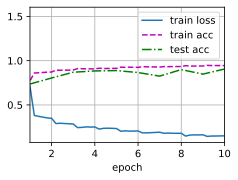

In [19]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())